In [2]:
import numpy as np

rng = np.random.default_rng(0)

In [11]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def logp_new(x):
    mu1 = -np.ones_like(x)
    mu2 = np.ones_like(x)
    term1 = np.exp(-0.5 * np.sum((x - mu1)**2))
    term2 = np.exp(-0.5 * np.sum((x - mu2)**2))
    return np.log(0.5 * term1 + 0.5 * term2)

def grad_logp_new(x):
    mu1 = -np.ones_like(x)
    mu2 = np.ones_like(x)
    term1_val = np.exp(-0.5 * np.sum((x - mu1)**2))
    term2_val = np.exp(-0.5 * np.sum((x - mu2)**2))

    numerator = term1_val * (-(x - mu1)) + term2_val * (-(x - mu2))
    denominator = term1_val + term2_val
    return numerator / denominator

In [12]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [13]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [15]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)
    chain = np.zeros((steps, d))
    accept = 0
    for t in range(steps):
        mu_prop = x + (step**2 / 2) * grad_logp(x)
        prop = rng.normal(mu_prop, step, size=d)
        log_q_x_prop = -0.5 * np.sum(((prop - mu_prop) / step)**2)
        mu_x = prop + (step**2 / 2) * grad_logp(prop)
        log_q_prop_x = -0.5 * np.sum(((x - mu_x) / step)**2)
        log_alpha = logp(prop) + log_q_prop_x - logp(x) - log_q_x_prop
        if np.log(rng.uniform()) < log_alpha:
            x = prop
            accept += 1
        chain[t] = x
    return chain, accept / steps

In [24]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

mala_step = 1.135
mh_scale = 0.798

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

mh_ess_vals = []
for i in range(d):
    mh_ess_vals.append(ess(mh_chain[burn:, i]))
median_mh_ess = np.median(mh_ess_vals)

mala_ess_vals = []
for i in range(d):
    mala_ess_vals.append(ess(mala_chain[burn:, i]))
median_mala_ess = np.median(mala_ess_vals)
print("Original distribution:")
print(f"MH AR: {mh_acc}")
print(f"MALA AR: {mala_acc}")
print(f"ESS for MH: {median_mh_ess}")
print(f"ESS for MALA: {median_mala_ess}")

logp = logp_new
grad_logp = grad_logp_new

mh_chain_new, mh_acc_new = mh(x0, steps, scale=mh_scale)
mala_chain_new, mala_acc_new = mala(x0, steps, step=mala_step)

mh_ess_vals_new = []
for i in range(d):
    mh_ess_vals_new.append(ess(mh_chain_new[burn:, i]))
median_mh_ess_new = np.median(mh_ess_vals_new)

mala_ess_vals_new = []
for i in range(d):
    mala_ess_vals_new.append(ess(mala_chain_new[burn:, i]))
median_mala_ess_new = np.median(mala_ess_vals_new)
print("New distribution:")
print(f"MH AR: {mh_acc_new}")
print(f"MALA AR: {mala_acc_new}")
print(f"ESS for MH: {median_mh_ess_new}")
print(f"ESS for MALA: {median_mala_ess_new}")

Original distribution:
MH AR: 0.23623333333333332
MALA AR: 0.5754666666666667
ESS for MH: 127.70131772307558
ESS for MALA: 139.67224772041578
New distribution:
MH AR: 0.2366
MALA AR: 0.5760666666666666
ESS for MH: 126.33537080536222
ESS for MALA: 138.3673541287662


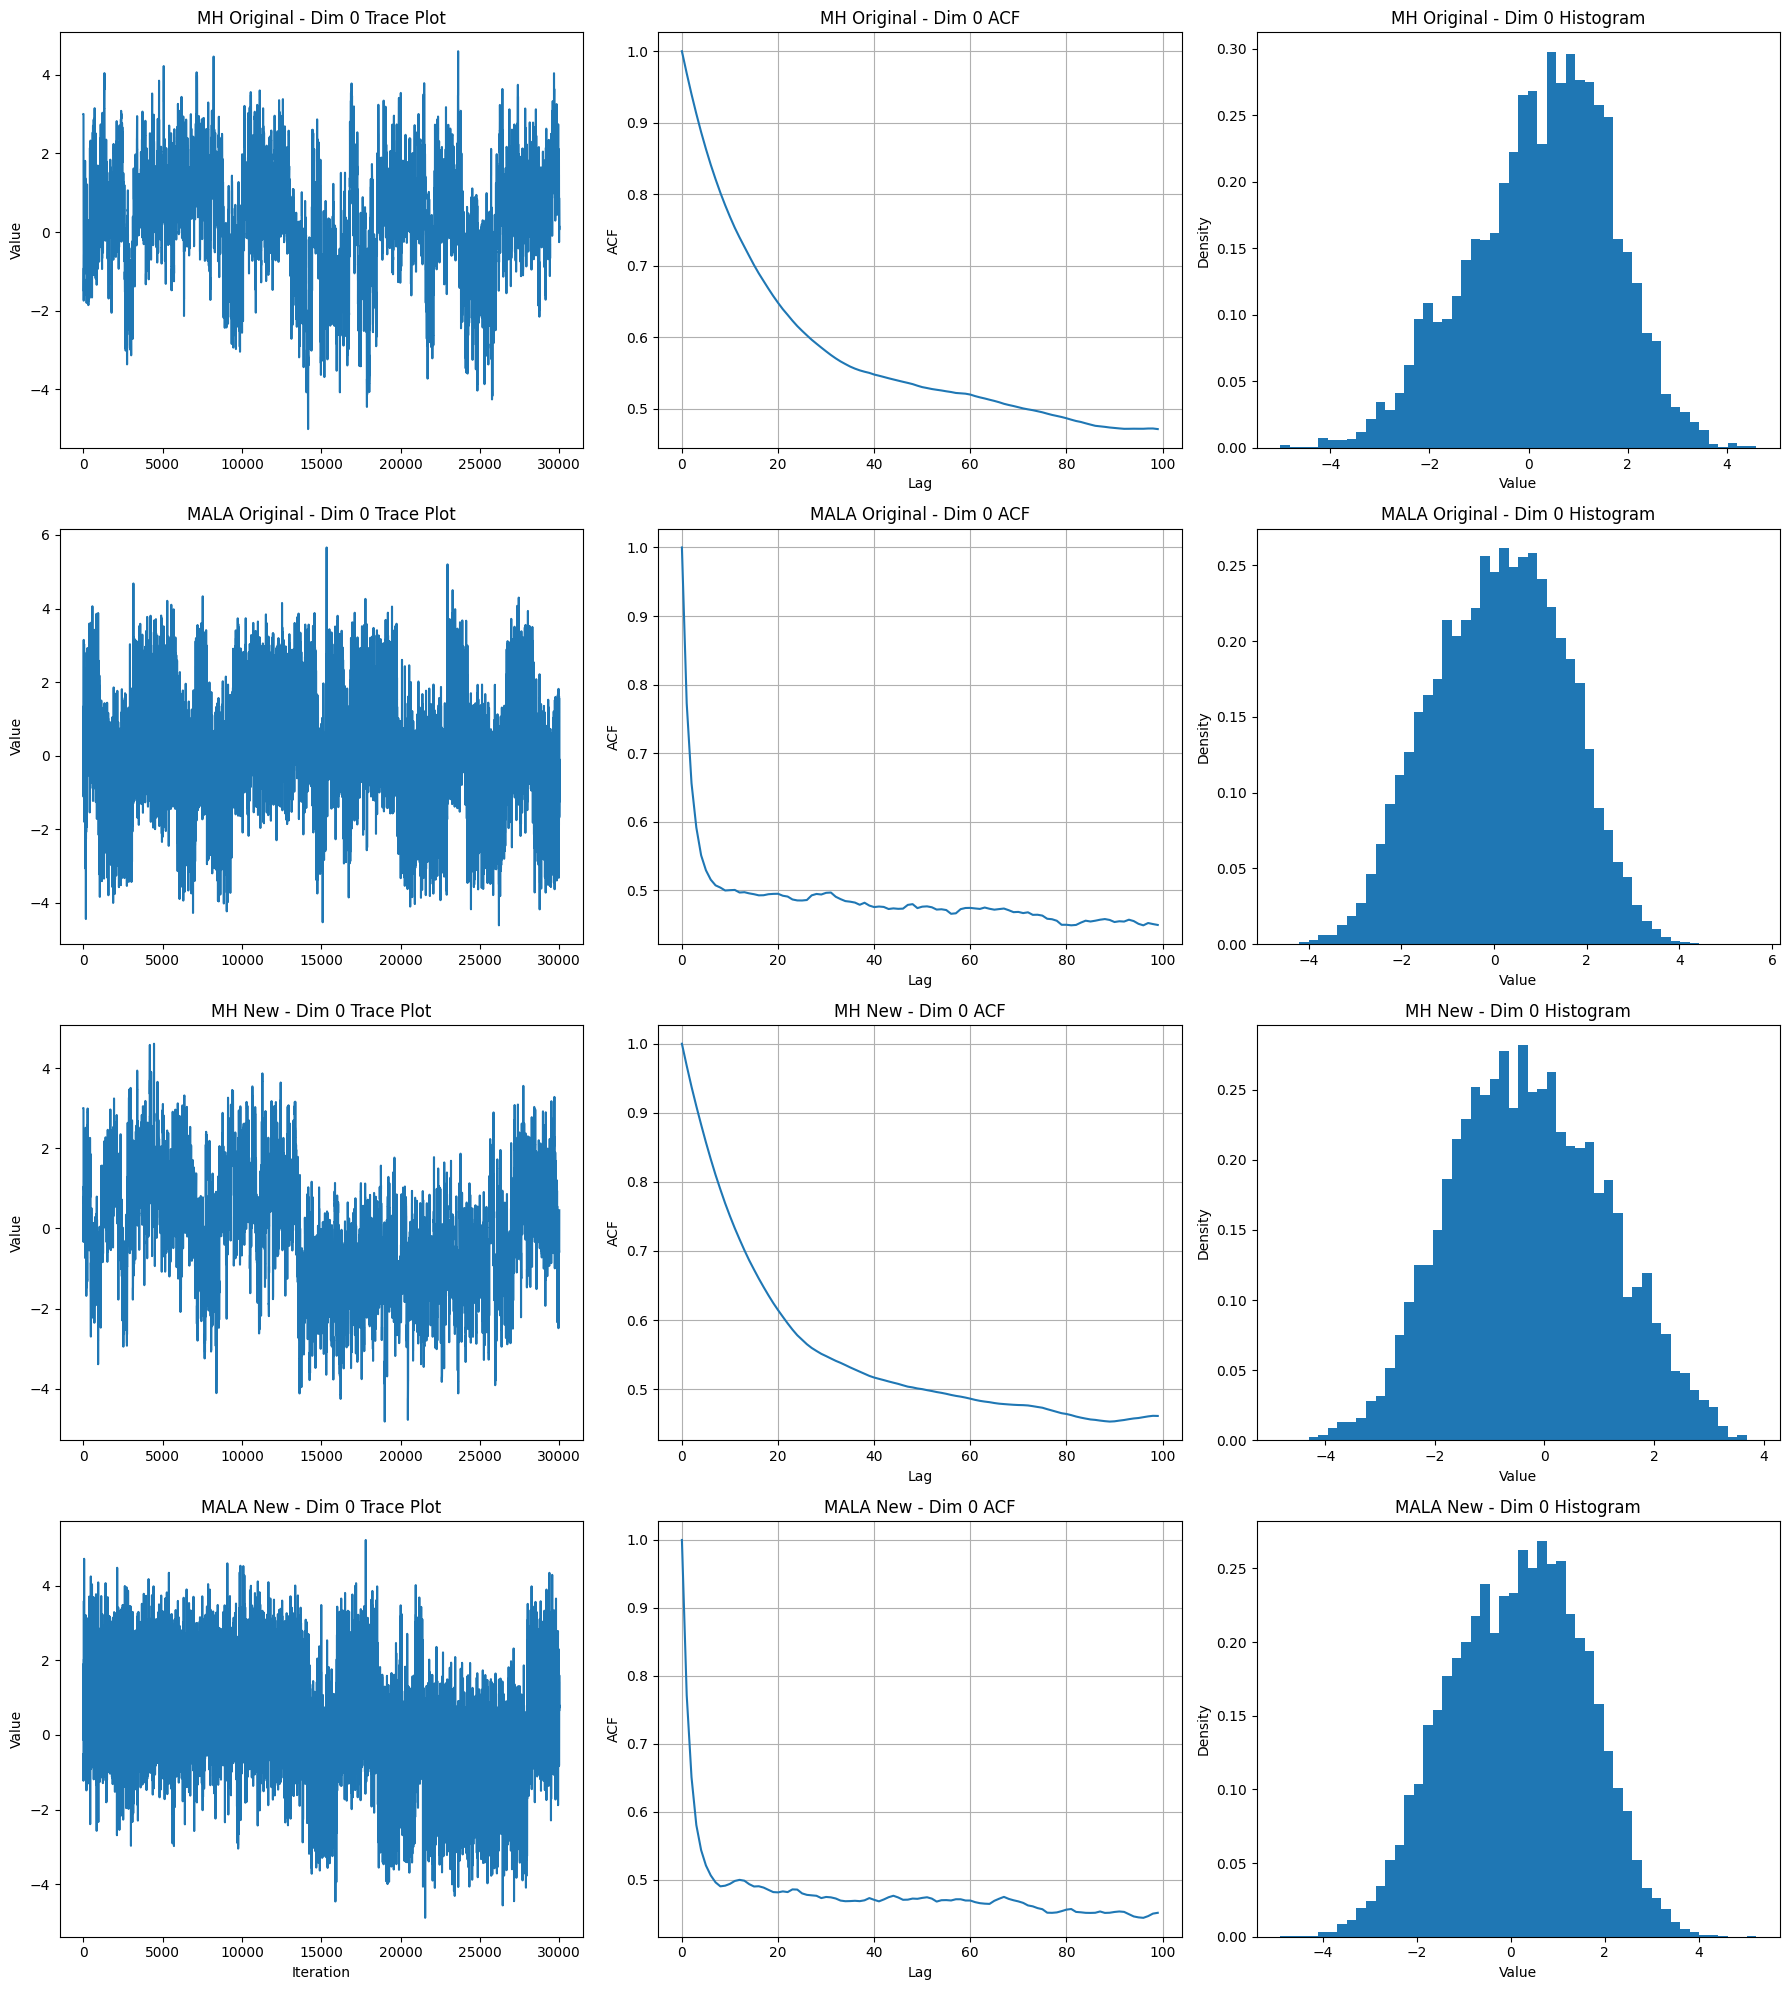

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf

def plot_autocorrelation(chain, title, ax):
    x = chain - chain.mean()
    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]
    ax.plot(acf[:100])
    ax.set_title(title)
    ax.set_xlabel('Lag')
    ax.set_ylabel('ACF')
    ax.grid(True)

plt.figure(figsize=(18, 20))

plt.subplot(4, 3, 1)
plt.plot(mh_chain[:, 0])
plt.title('MH Original - Dim 0 Trace Plot')
plt.ylabel('Value')

plt.subplot(4, 3, 2)
plot_autocorrelation(mh_chain[burn:, 0], 'MH Original - Dim 0 ACF', plt.gca())

plt.subplot(4, 3, 3)
plt.hist(mh_chain[burn:, 0], bins=50, density=True)
plt.title('MH Original - Dim 0 Histogram')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(4, 3, 4)
plt.plot(mala_chain[:, 0])
plt.title('MALA Original - Dim 0 Trace Plot')
plt.ylabel('Value')

plt.subplot(4, 3, 5)
plot_autocorrelation(mala_chain[burn:, 0], 'MALA Original - Dim 0 ACF', plt.gca())

plt.subplot(4, 3, 6)
plt.hist(mala_chain[burn:, 0], bins=50, density=True)
plt.title('MALA Original - Dim 0 Histogram')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(4, 3, 7)
plt.plot(mh_chain_new[:, 0])
plt.title('MH New - Dim 0 Trace Plot')
plt.ylabel('Value')

plt.subplot(4, 3, 8)
plot_autocorrelation(mh_chain_new[burn:, 0], 'MH New - Dim 0 ACF', plt.gca())

plt.subplot(4, 3, 9)
plt.hist(mh_chain_new[burn:, 0], bins=50, density=True)
plt.title('MH New - Dim 0 Histogram')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(4, 3, 10)
plt.plot(mala_chain_new[:, 0])
plt.title('MALA New - Dim 0 Trace Plot')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(4, 3, 11)
plot_autocorrelation(mala_chain_new[burn:, 0], 'MALA New - Dim 0 ACF', plt.gca())

plt.subplot(4, 3, 12)
plt.hist(mala_chain_new[burn:, 0], bins=50, density=True)
plt.title('MALA New - Dim 0 Histogram')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

Цепь MALA имеет более высокий ESS.

Автокорреляция выборки затухает быстрее.

Наблюдается лучшее перемешивание цепи, так как:

1. Цепь MALA имеет более высокий ESS.

2. Автокорреляция выборки затухает быстрее.

3. Наблюдается лучшее перемешивание цепи.